In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import matplotlib.pyplot as plt

from matplotlib import cm
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import LSTM, AttentionLSTM
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores, plot_losses, plot_results

torch.manual_seed(0)

#### Import data and set quantiles

In [6]:
PATH = Path.cwd()
PATH_DATA = PATH.parent / 'data'

In [7]:
data = pd.read_csv((PATH_DATA / 'hourly-energy-price.csv'), sep=';', index_col='datetime')
data.index = pd.to_datetime(data.index)

#hours ahead to predict
hours_ahead = 24

# add the target and transform it to pct
data['target'] = data['value'].shift(-hours_ahead)
data = data.pct_change()

# dropnas
data.dropna(inplace=True)

In [13]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# lookback periods
slide = 24

## LSTM USING ONLY THE TARGET

In [14]:
# intialize frametorch
frametorch = FrameTorch(data, target_name='target')
# split data
frametorch.split_data()
# scale data
# frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

#### MODEL PREPARATION

In [15]:
# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [16]:
# model
quantilenet = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=n_inputs, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet.parameters(), lr=0.001)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [17]:
quantilenet = trainer.fit(
    train_loader, val_loader, epochs=200, n_logger=10, patience=20
)

epoch: 0 train loss: 2.097 val loss: 1.229
epoch: 10 train loss: 0.102 val loss: 0.107
epoch: 20 train loss: 0.102 val loss: 0.107


## LSTM WITH ATTENTION

In [18]:
# intialize frametorch
frametorch_att = FrameTorch(data, target_name='target')
# split data
frametorch_att.split_data()
# scale data
# frametorch_att.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_att.data_to_loader(slide=slide)

#### MODEL PREPARATION

In [19]:
# number of inputs and outputs
n_inputs = frametorch_att.data.shape[1] - 1
n_outputs = len(quantiles)

In [20]:
# model
quantilenet_att = AttentionLSTM(embed_dim=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_att.parameters(), lr=0.001)
# trainer class
trainer_att = Trainer(quantilenet_att, criterion, optimizer)

#### TRAIN DE MODEL

In [ ]:
quantilenet_att = trainer_att.fit(
    train_loader, val_loader, epochs=200, n_logger=10, patience=20
)

epoch: 0 train loss: 0.11 val loss: 0.106
epoch: 10 train loss: 0.101 val loss: 0.11
epoch: 20 train loss: 0.083 val loss: 0.091


## COMPARE MODELS

In [ ]:
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

# validation input and target
inputs, target = val_loader.dataset.inputs, val_loader.dataset.target

# target to ss
_index = data.index[frametorch.n_train+slide-1 : frametorch.n_val+frametorch.n_train]
y_test = pd.Series(target.squeeze().tolist(), index=_index)

# quantilenet predictions
y_pred_quantilenet = quantilenet(inputs)
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist(), index=_index)

Predictions without spread

In [ ]:
train_loader, val_loader, test_loader = frametorch_att.data_to_loader(slide=slide)

# validation input and target
inputs, _ = val_loader.dataset.inputs, val_loader.dataset.target

# quantilenet predictions
y_pred_quantilenet_att = quantilenet_att(inputs)
y_preds_quantilenet_att = pd.DataFrame(y_pred_quantilenet_att.tolist(), index=_index)

### COMPARE MODEL TYPES

Convergence

In [ ]:
plot_losses(trainer, trainer_att)

Scores

In [ ]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
quantilenet_att_scores = get_scores(y_pred_quantilenet_att, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, quantilenet_att_scores], axis=1, keys=['LSTM', 'Attention + LSTM']
)
final_scores

Plots

In [ ]:
plot_results(
    y_preds_quantilenet, y_preds_quantilenet_att, y_test
)

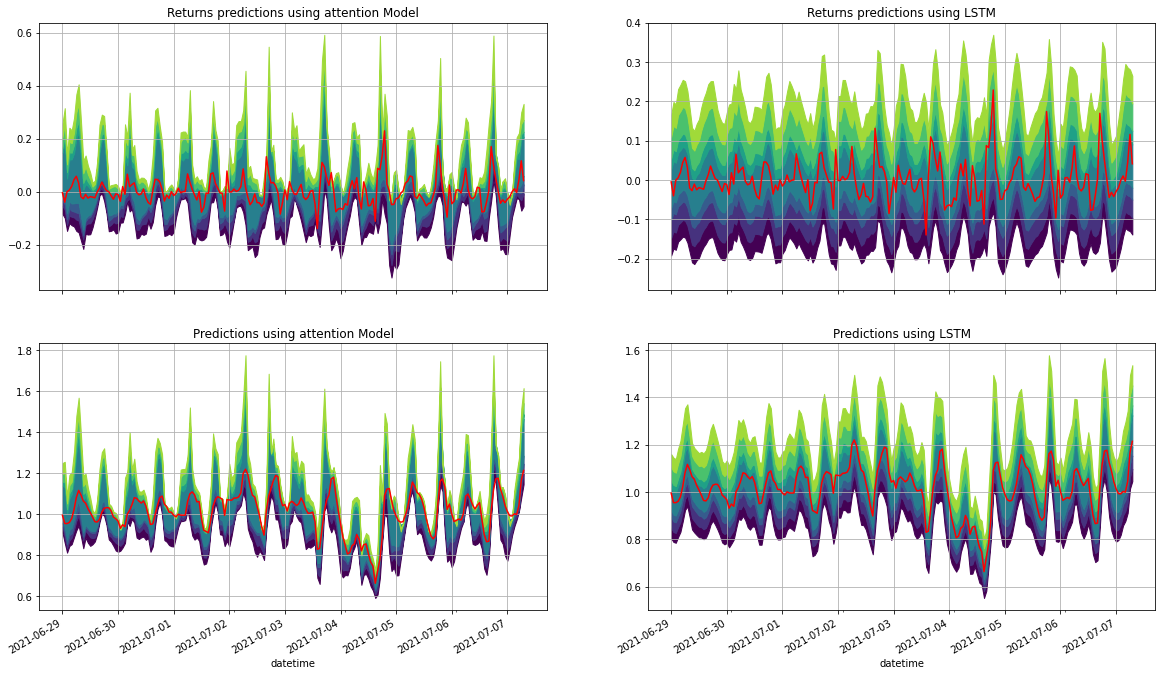